# MNIST Autoencoder
# Author: Huygens Ravelomanana
# Description
We create two different autoencoders for the MNIST data:
1. A Stacked autoencoder with tied weights
2. Convolutional Encoder (conv, maxpool, conv, maxpool, conv, maxpool). Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)




# Importing libraries

In [1]:
# commented since already running Python 3 runtime
# Choose Python 3 runtime
#!pip install --upgrade tensorflow

In [2]:
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import  (Conv2D,
                                      MaxPool2D,
                                      UpSampling2D)
                                      # not needed Conv2DTranspose) 


from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.callbacks import EarlyStopping

from keras.datasets import mnist


# Loading data - data exploration

In [3]:

(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()


In [4]:
# scaling the pictures to the [0,1] range 
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# creating train and validation data
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

In [5]:
def print_first_9(data):
    """"Printing the first 9 elements in the input data
    Input:
    ------
             data (numpy.ndarray): an array of image samples.
    Ouput:
    -----
             None, Just show images.
    """
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i], cmap='gray')
        plt.title("Digit: {}".format(i))
        plt.xticks([])
        plt.yticks([])

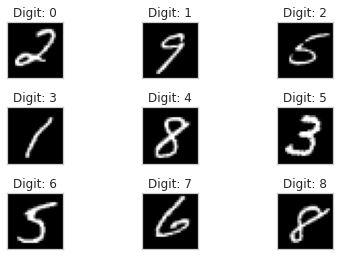

In [6]:
# printing some images
print_first_9(X_train_full[-9:])

# Utility functions

In [7]:
def rounded_accuracy(y_true, y_pred):
    """"Compute binary accuracy using rounded version of the input.
    Input:
    -----
           y_true: true values
                   shape = [batch_size, d0, .. dN].
           
           y_pred: prediction
                   shape = [batch_size, d0, .. dN].

    Output:
    -------
           Binary accuracy values. shape = [batch_size, d0, .. dN-1]
    """
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [8]:
def plot_image(image, title="image"):
    """"Plot an image with a title.
    Input:
    -----
           image: an array-like or PIL image
           
           title(str): a title for the image.

    Output:
    -------
    """
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")


def show_reconstructions(model, images, n_images=5):
    """"Predict using images then show some images from images
    and the corresponding prediction.

    Input:
    -----
            model:  already trained model

            images (numpy.ndarray): an array of image samples.

            n_images (int): number of predicted image to show

    Output:
    -------
            None.
    """
    # predict with the model using the first n_images in images
    # as features
    reconstructions = model.predict(images[:n_images])

    # reshape images from 4D to (-1, 28, 28) 
    reconstructions = reconstructions.reshape(-1, 28, 28)
    images = images.reshape(-1, 28, 28)

    # plot the images
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    for image_index in range(n_images):
        # the original image
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index], 'original')

        # the reconstructed images
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index],
                   'reconstruction')
        
        # for nice space between pictures
        fig.tight_layout()

In [9]:
# Creating a function which plots loss or accuracy curve
def plot_train_val_curves(history):
    """Function plotting the train and validation loss and accuracy curves
    INPUT:
    -----   
            history (tensorflow.python.keras.callbacks.History):
                     output of the .fit() method of a keras Model instance
    OUTPUT:
    ------
            None (it shows some plots)
    """

    # creating figure and axis for the plot
    fig, axes = plt.subplots(1,2, figsize=(20,8))

    # train and validation loss plot
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Model Loss Progress During Training', fontsize=15)
    axes[0].set_ylabel('Training and Validation Loss', fontsize=12)
    axes[0].set_xlabel('Epoch number', fontsize=12)
    axes[0].legend(['Training Loss', 'Validation Loss'], fontsize=12)

    # train and validation accuracy plot
    axes[1].plot(history.history['rounded_accuracy'])
    axes[1].plot(history.history['val_rounded_accuracy'])
    axes[1].set_title('Model accuracy Progress During Training', fontsize=15)
    axes[1].set_ylabel('Training and Validation accuracy', fontsize=12)
    axes[1].set_xlabel('Epoch number', fontsize=12)
    axes[1].legend(['Training accuracy', 'Validation accuracy'], fontsize=12)

    plt.show()



# Stacked 784 - 392 - 196 - 392 - 784 (tied weights)

## Tying Weights
Tying weight, that is using the transpose of the encoder's weights as the decoder weights, not training them.
For this, we need to use a 

In [10]:
class DenseTranspose(keras.layers.Layer):
    """A class inheritance from  keras.layers.Layer to be
      used as custom layer creating a transpose of the weights of
      a Dense layer (the encoder)."""

    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

## Flatting the images
+ The input for the encoder are vectors i.e 1D arrays so we have to reshape our images into 1D array instead of a 2D array (28 x 28 matrix).

In [11]:
# converting each matrix image into 1D vector: 28*28 = 784
X_train_flattened =  X_train.reshape(-1, 784)
X_val_flattened =  X_val.reshape(-1, 784)
X_test_flattened =  X_test.reshape(-1, 784)

In [12]:
# printing the shape of the data to verify
print(X_train_flattened.shape)
print(X_val_flattened.shape)
print(X_train_flattened.shape)

(55000, 784)
(5000, 784)
(55000, 784)


## Creating and training the tied weights dense model

In [13]:
# defining a learning rate scheduler function
def scheduler(epoch, lr):
    """Learning rate scheduler:
    Input:
    -----
          epoch (int): The current epoch.
          lr (float): The initial learning rate.
    
    Output:
    ------
          (float) the learning rate for the current epoch.
    """
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(0.1*(5-epoch))

In [14]:
#784 - 392 - 196 - 392 - 784 (tied weights)
%%time

# freeing memory - removing potentially conflicating data
keras.backend.clear_session()

# setting seed for random in order to get reproducible results
# the 42 is just a famous number from a movie
# Answer to the Ultimate Question of Life, the Universe, and Everything.
tf.random.set_seed(42)
np.random.seed(42)

# The encoder
########################

# 1st fully connected layer of size 786
dense_1 = keras.layers.Dense(784, activation="selu")

# 2nd fully connected layer of size 392
dense_2 = keras.layers.Dense(392, activation="selu")

# 3rd fully connected layer of size 196
# using only the 2 layers yeld better accuracy but we want
# the images to be compressed further
dense_3 = keras.layers.Dense(196, activation="selu")

# the encoder
tied_encoder = Sequential([dense_1, dense_2, dense_3])

# The decoder
########################
tied_decoder = Sequential([DenseTranspose(dense_3,
                                          activation="selu"),
                           DenseTranspose(dense_2,
                                          activation="selu"),
                           DenseTranspose(dense_1,
                                          activation="sigmoid")])


# The AutoEncoder
########################
tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])


tied_ae.compile(loss="binary_crossentropy",
                optimizer=Nadam(learning_rate=0.001),
                metrics=[rounded_accuracy])

early_stop = EarlyStopping(monitor='val_rounded_accuracy',
                           patience=1)


tied_history = tied_ae.fit(X_train_flattened,
                           X_train_flattened,
                           validation_data=(X_val_flattened,
                                            X_val_flattened),
                           epochs=20,
                           callbacks=[early_stop],
                           verbose=2)
    

Epoch 1/20
1719/1719 - 6s - loss: 0.0918 - rounded_accuracy: 0.9727 - val_loss: 0.0804 - val_rounded_accuracy: 0.9802
Epoch 2/20
1719/1719 - 5s - loss: 0.0736 - rounded_accuracy: 0.9839 - val_loss: 0.0754 - val_rounded_accuracy: 0.9827
Epoch 3/20
1719/1719 - 5s - loss: 0.0896 - rounded_accuracy: 0.9786 - val_loss: 0.0749 - val_rounded_accuracy: 0.9832
Epoch 4/20
1719/1719 - 5s - loss: 0.0718 - rounded_accuracy: 0.9850 - val_loss: 0.0710 - val_rounded_accuracy: 0.9861
Epoch 5/20
1719/1719 - 5s - loss: 0.0705 - rounded_accuracy: 0.9862 - val_loss: 0.0706 - val_rounded_accuracy: 0.9865
Epoch 6/20
1719/1719 - 5s - loss: 0.0697 - rounded_accuracy: 0.9869 - val_loss: 0.0708 - val_rounded_accuracy: 0.9864
CPU times: user 43.8 s, sys: 7.91 s, total: 51.7 s
Wall time: 30.8 s


In [15]:
# summary of the autoencoder
tied_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 196)               1000188   
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1002148   
Total params: 1,002,148
Trainable params: 1,002,148
Non-trainable params: 0
_________________________________________________________________


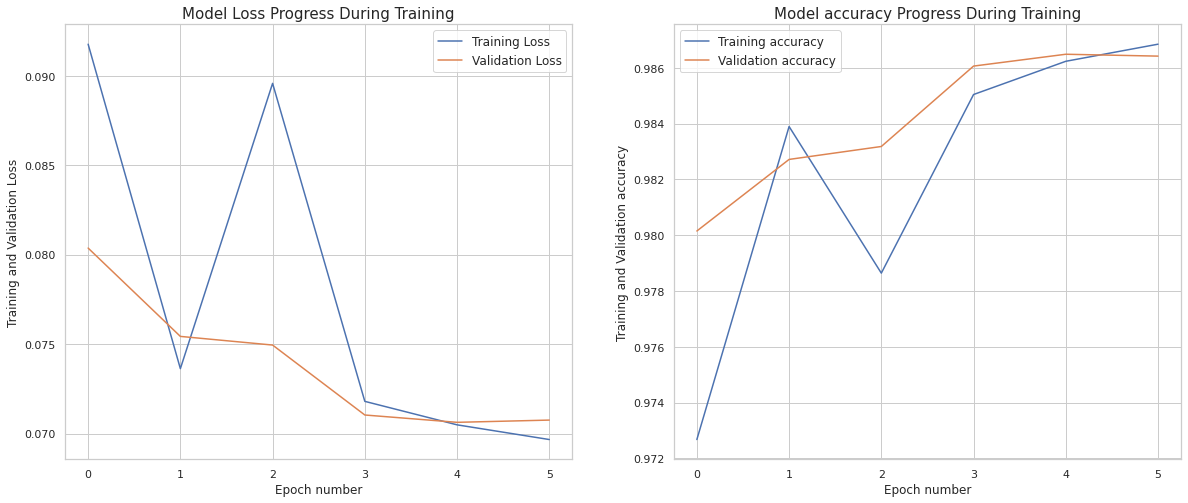

In [16]:
# plotting the train vs validation loss and accuracy
plot_train_val_curves(tied_history)

## Evaluating tied_ae on Unseen data (Test set)

In [17]:
# evaluating on test data
tied_ae_test_result = tied_ae.evaluate(X_test_flattened, X_test_flattened)
tied_ae_test_result

313/313 [==============================] - 1s 2ms/step - loss: 0.0697 - rounded_accuracy: 0.9867


[0.06966471672058105, 0.9866551756858826]

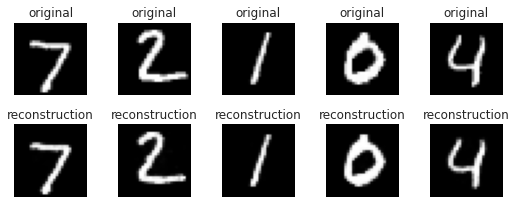

In [18]:
# showing reconstruction of X_test
show_reconstructions(tied_ae, X_test_flattened)
plt.show()

# Convolutional AutoEncoder
We found that the following configuration work best:
 + Encoder (conv, maxpool, conv, maxpool, conv, maxpool).
 + Decoder (UpSampling, Conv, UpSampling, Conv, UpSampling, Conv, UpSampling, Conv)

## Reshaping the data into 4D: (#smaples, height, width, channels) 
+ Convolutional layers take 4D tensor as input so we need to reshape our data accordingly .

In [19]:
# converting each matrix image into 3D 
X_train_3d =  X_train.reshape(-1, 28, 28, 1)
X_val_3d =  X_val.reshape(-1, 28, 28, 1)
X_test_3d =  X_test.reshape(-1, 28, 28, 1)

print(X_train_3d.shape)
print(X_val_3d.shape)
print(X_test_3d.shape)

(55000, 28, 28, 1)
(5000, 28, 28, 1)
(10000, 28, 28, 1)


## Creating and training the convolutional autoencoder

**We are going to use two separate functions to create the encoder and the decoder unlike for the Dense case**

In [20]:

# the encoder
def create_conv_encoder():
    """Creating and encoder using convolution.
     
    INPUT:
    ------
            None
    
    OUTPUT:
    -------
           conv_encoder (keras.models.Sequential): an uncompiled model
                                                   to be used as encoder
    """

    # creating an instance of keras Sequential class
    conv_encoder = Sequential()

    # 1st convolution layer
    conv_encoder.add(Conv2D(64,
                            input_shape=(28, 28, 1),
                            kernel_size=3,
                            padding="SAME",
                            activation="selu"))
    
    #  Max pooling layer
    conv_encoder.add(MaxPool2D(pool_size=2))

    # 2nd convolution layer
    conv_encoder.add(Conv2D(32,
                            kernel_size=3,
                            padding="SAME",
                            activation="selu"))

    #  Max pooling layer
    conv_encoder.add(MaxPool2D(pool_size=2))

    # 3rd and last convolution layer
    conv_encoder.add(Conv2D(16,
                            kernel_size=3,
                            padding="SAME",
                            activation="selu"))
    
    #  Max pooling layer
    conv_encoder.add(MaxPool2D(pool_size=2))

    # returning the created model
    return conv_encoder


In [21]:
# the decoder
def create_conv_decoder():
    """Creating and encoder using convolution.
     
    INPUT:
    ------
            None
    
    OUTPUT:
    -------
           conv_decoder (keras.models.Sequential): an uncompiled model
                                                   to be used as decoder
    """

    # creating an instance of keras Sequential class
    conv_decoder = Sequential()

    # UpSampling using bilinear interpolation
    conv_decoder.add(UpSampling2D(size=3,
                                  input_shape=[3, 3, 16],
                                  interpolation='bilinear'))

    # 1st convolution
    conv_decoder.add(Conv2D(16,
                            kernel_size=1,
                            strides=1,
                            padding="SAME",
                            activation="selu"))
    
    # UpSampling using bilinear interpolation
    conv_decoder.add(UpSampling2D(size=3,
                                  interpolation='bilinear'))
     
    # 2nd convolution
    conv_decoder.add(Conv2D(32,
                            kernel_size=2,
                            strides=2,
                            padding="SAME",
                            activation="selu"))
    
    # UpSampling using bilinear interpolation     
    conv_decoder.add(UpSampling2D(size=2,
                                  interpolation='bilinear'))

    # 3rd convolution
    conv_decoder.add(Conv2D(64,
                            kernel_size=3,
                            strides=2,
                            padding="SAME",
                            activation="selu"))

    # UpSampling using bilinear interpolation     
    conv_decoder.add(UpSampling2D(size=2,
                                  interpolation='bilinear'))
    
    # 4th and last convolutional layer
    conv_decoder.add(Conv2D(1,
                            kernel_size=2,
                            strides=1,
                            padding="SAME",
                            activation="sigmoid"))
    
    # returning the created model
    return conv_decoder


In [22]:
%%time

# freeing memory - removing potentially conflicating data
K.clear_session()


# setting seed for random in order to get reproducible results
tf.random.set_seed(42)
np.random.seed(42)

# creating a convolutional encoder 
conv_encoder = create_conv_encoder()

# creating a convolutional decoder 
conv_decoder = create_conv_decoder()

# creating a convolutional AutoEncoder
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

# compiling the AutoEncoder
conv_ae.compile(loss="binary_crossentropy",
                optimizer=Nadam(learning_rate=0.001),
                metrics=[rounded_accuracy])


# learning rate scheduler
lambda_cnn_sched = lambda _ : scheduler( _ , 0.001)
cnn_lr_sched = LearningRateScheduler(lambda_cnn_sched)

# defining an early stopping
early_stop = EarlyStopping(monitor='val_rounded_accuracy',
                           patience=6)


# training the AutoEncoder
conv_history = conv_ae.fit(X_train_3d,
                           X_train_3d,
                           validation_data=(X_val_3d,
                                            X_val_3d),
                          #batch_size = 512,
                          epochs=200,
                          callbacks=[early_stop],
                          verbose=2)

Epoch 1/200
1719/1719 - 11s - loss: 0.1663 - rounded_accuracy: 0.9246 - val_loss: 0.1362 - val_rounded_accuracy: 0.9428
Epoch 2/200
1719/1719 - 9s - loss: 0.1273 - rounded_accuracy: 0.9482 - val_loss: 0.1209 - val_rounded_accuracy: 0.9533
Epoch 3/200
1719/1719 - 9s - loss: 0.1139 - rounded_accuracy: 0.9568 - val_loss: 0.1131 - val_rounded_accuracy: 0.9567
Epoch 4/200
1719/1719 - 9s - loss: 0.1063 - rounded_accuracy: 0.9615 - val_loss: 0.1045 - val_rounded_accuracy: 0.9629
Epoch 5/200
1719/1719 - 9s - loss: 0.1016 - rounded_accuracy: 0.9646 - val_loss: 0.1023 - val_rounded_accuracy: 0.9648
Epoch 6/200
1719/1719 - 9s - loss: 0.0983 - rounded_accuracy: 0.9667 - val_loss: 0.0973 - val_rounded_accuracy: 0.9676
Epoch 7/200
1719/1719 - 9s - loss: 0.0957 - rounded_accuracy: 0.9683 - val_loss: 0.0986 - val_rounded_accuracy: 0.9668
Epoch 8/200
1719/1719 - 9s - loss: 0.0939 - rounded_accuracy: 0.9695 - val_loss: 0.0945 - val_rounded_accuracy: 0.9692
Epoch 9/200
1719/1719 - 9s - loss: 0.0923 - rou

In [23]:
# summary of the encoder
conv_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
Total params: 23,728
Trainable params: 23,728
Non-trainable params: 0
____________________________________________________

In [24]:
# summary of the decoder
conv_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 16)          272       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        2080      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 64)       

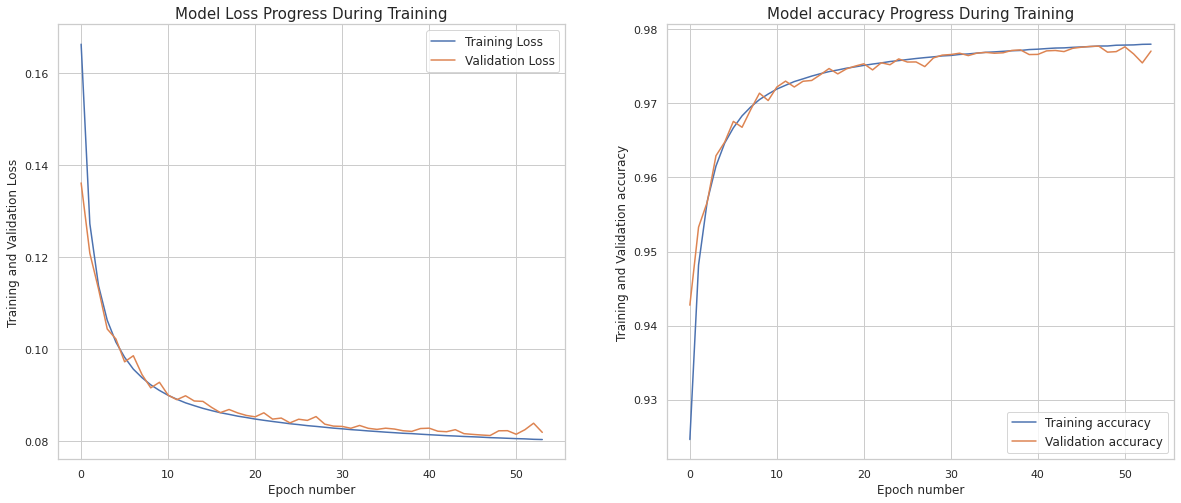

In [25]:
# plotting the train vs validation loss and accuracy
plot_train_val_curves(conv_history)

## Evaluating conv_ae on Unseen data (Test set)

In [26]:
# evaluating on test data
conv_test_result = conv_ae.evaluate(X_test_3d, X_test_3d)
conv_test_result

313/313 [==============================] - 1s 3ms/step - loss: 0.0804 - rounded_accuracy: 0.9778


[0.08038011193275452, 0.9777657985687256]

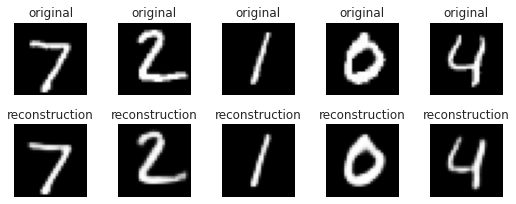

In [27]:
# showing reconstruction of X_test
show_reconstructions(conv_ae, X_test_3d)
plt.show()

# Final Comments
+ The tied weights MLP autoencoder performed better with 98.67% test accuracy (unseen data).
+ The convolutional model with upsampling instead of transpose convolution performed less but still got a 97.76% test accuracy (unseen data) with very good reproduction as seen in the images above.